# 모듈 임포트

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
import pandas as pd

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# 데이터 적재 train_X_case(dict), train_y_case(dict)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_X_case = {}

for i in range(1, 29):
    train_X_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_input/CASE_{}.csv".format(str(i).zfill(2)))
 

In [ ]:
train_y_case = {}

for i in range(1, 29):
    train_y_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_target/CASE_{}.csv".format(str(i).zfill(2)))
 

In [ ]:
train_X_case["01"].head(3)

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


In [ ]:
train_y_case["01"].head(3)

,DAT,predicted_weight_g
0,1,0.167719
1,2,0.181787
2,3,0.265921


 28개의 상추를 28일 동안 24시간 간격으로 측정한 데이터이다.

 28 * 24 = 672

 - feature는 16개
 - train_y는 매일 측정된 상추의 잎 크기이다.

 잎의 성장은 전날의 데이터에 영향을 받는다. (청경채 예측 분석 코드공유를 참고함.)

 각 상추의 train_X를 28개로 나눈 뒤, 하루 뒤의 train_y를 예측하게 할 것이다.

 https://dacon.io/competitions/official/235961/overview/description

상추의 생육환경 예측과 비슷한 문제인 청경채 성장 경진대회를 많이 참고할 예정이다.

# 데이터 전처리

- 데이터셋 나누기 
    1. 28개의 상추를 하루 단위씩 끊어서 데이터셋을 새로 만들기
    2. 하루단위 데이터를 평균낸 데이터를 다시 합쳐서 데이터셋을 새로 만들기

- target 데이터 전처리
    1. 전날 대비 성장률 추가 
    2. 초기 대비 성장률 추가

- null 값 처리

- 컬럼별 상관관계 보기

- 이상치 처리

- 노이즈값 처리

### 데이터셋 합치기 train_all_X(DataFrame)
모든데이터를 합친다.

In [ ]:
train_all_X = pd.DataFrame()

for i in range(1,29):
    CASE = str(i).zfill(2)
    train_all_X = train_all_X.append(train_X_case[CASE])

In [ ]:
train_all_X.shape

(18816, 16)

### 데이터셋 나누기 train_X_case_day(list)

각 상추의 28일치 데이터를 분리해서 저장한다.

In [ ]:
# train_X_case_day[x][y] 를 입력하면 x 케이스의 y번째 날 데이터 프레임을 리턴함
# case는 1~28, day는 0~27 
train_X_case_day = [[]]

for i in range(1,29):
    train_X_case_day.append([])
    for j in range(1,29):
        train_X_case_day[i].append(train_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

### 타겟데이터 전처리 train_y_all(DF)


In [ ]:
for case in range(1,29):
    CASE = str(case).zfill(2)
    IGR = []                    # 초기 대비 성장률(initial growth rate): IGR
    DOD = []                    # 전날 대비 성장률(day over day growth rate): DOD
    GGG = []


    IGR.append(0)
    DOD.append(0)
    GGG.append(train_y_case[CASE].iloc[0,1])
    for day in range(1, 28):
        id = train_y_case[CASE].iloc[0, 1]          # inital day
        yd = train_y_case[CASE].iloc[(day-1),1]     # yester day
        td = train_y_case[CASE].iloc[day, 1]        # today
        
        GGG.append(td-yd)
        IGR.append((td-id)/id*100)
        DOD.append((td-yd)/yd*100)

    train_y_case[CASE]["초기 대비 성장률(%)"] = IGR
    train_y_case[CASE]["전날 대비 성장률(%)"] = DOD
    train_y_case[CASE]["전날 대비 성장(g)"] = GGG

In [ ]:
train_y_all = pd.DataFrame()

for i in range(1, 29):
    CASE = str(i).zfill(2)
    train_y_all = train_y_all.append(train_y_case[CASE].drop(["DAT"], axis=1), ignore_index=True)

In [ ]:
# 28 * 28 사이즈의 데이터셋 생성

train_y_all.shape

(784, 4)

In [ ]:
# 하루씩 타겟 데이터가 밀려있기 때문에 0일째 인덱스는 삭제해야한다.

rate_index = [i for i in range(0, 784)]


for i in range(1,29):
    rate_index.remove((i-1)*28)

In [ ]:
train_y_W = train_y_all.iloc[:, 0]
train_y_R = train_y_all.iloc[rate_index, 2]
train_y_G = train_y_all.iloc[rate_index, 3]

In [ ]:
train_y_W[280]

11.7641629206507

### null 값 처리

null 값이 없다.

In [ ]:
for i in range(1, 29):
    CASE = str(i).zfill(2)
    for _ in train_X_case[CASE].isnull().sum():
        if _ == True:
            print(_)

### 노이즈값 처리

- 시간당 내부 평균온도: 4도~40도
- 시간당 내부 평균습도: 0% ~ 100%
- 시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm
- 시간당 평균 EC : 0 ~ 8
- 시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000
- 시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000
- 시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000 
- 시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000
- 시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000




In [ ]:
col = train_X_case["01"].columns
col

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

In [ ]:
control_variable = pd.DataFrame()

noise = [[]]

for i in range(1, 29):
    noise.append([])
    CASE = str(i).zfill(2)

    # 내부 온도 관측치 
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]<4].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]>40].index)   

    # 내부습도 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]<=0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]>100].index)   

    # co2 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]<=0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]>1200].index)   

    # ec 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]>8].index)   

    # 시간당 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]>3000].index)   

    # 누적 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]>72000].index)   

    # 시간당 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]>120000].index)   

    # 일간 누적 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]> 2880000].index)   

    # 시간당 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]>120000].index)   

    # 일간 누적 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]>2880000].index)   

    # 시간당 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]>120000].index)   

    # 일간 누적 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]>2880000].index)   

    # 시간당 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]>120000].index)   

    # 일간 누적 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]>2880000].index)   

    # # 중복값 제거
    # noise[i] = list(set(noise[i]))

In [ ]:
for i in range(1, 29):
    for j in range(28):
        if len(noise[i][j]) != 0 and len(noise[i][j])<100:
            print("case{} {}".format(i, col[j//2+2]))
            print(noise[i][j], "\n")

case1 co2관측치
Int64Index([639, 640, 641, 642], dtype='int64') 

case3 co2관측치
Int64Index([ 12,  15,  16,  17,  18,  19,  20,  36,  39,  40,  41,  42,  43,
             44,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 159, 160,
            161, 162, 180, 181, 182, 183, 184, 185, 186, 187, 188, 204, 205,
            206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 252, 253, 254, 255, 256, 257, 258, 259, 260, 325,
            326, 327, 328, 329, 330, 331, 332, 333, 334, 350, 351, 352, 353,
            354, 355, 356, 395, 396, 397, 400, 401, 402, 403, 404, 662, 663,
            664, 665, 666, 667, 668],
           dtype='int64') 

case4 내부온도관측치
Int64Index([15], dtype='int64') 

case4 내부습도관측치
Int64Index([15], dtype='int64') 

case4 co2관측치
Int64Index([549], dtype='int64') 

case6 시간당백색광량
Int64Index([15], dtype='int64') 

case6 시간당적색광량
Int64Index([15], dtype='int64') 

case6 시간당청색광량
Int64Index([15], dtype='int64') 

case6 시간당총광량
Int64Index([15], d

일단 값이 틀린 칼럼과 인덱스는 찾았으니, 대입할 값은 나중에 처리해보자.

#### co2 관측치

In [ ]:
# case 1 co2관측치
train_X_case["01"].loc[[637,638, 639, 640, 641, 642, 643, 644], "co2관측치"]

637     682.600000
638     997.916667
639    1225.066667
640    1220.583333
641    1217.500000
642    1264.366667
643    1077.850000
644    1043.066667
Name: co2관측치, dtype: float64

In [ ]:
# case 3 co2관측치
train_X_case["03"].loc[[ 12,  15,  16,  17,  18,  19,  20,  36,  39,  40,  41,  42,  43,
             44,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 159, 160,
            161, 162, 180, 181, 182, 183, 184, 185, 186, 187, 188, 204, 205,
            206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 252, 253, 254, 255, 256, 257, 258, 259, 260, 325,
            326, 327, 328, 329, 330, 331, 332, 333, 334, 350, 351, 352, 353,
            354, 355, 356, 395, 396, 397, 400, 401, 402, 403, 404, 662, 663,
            664, 665, 666, 667, 668], "co2관측치"]

12     1219.633333
15     1260.616667
16     1261.050000
17     1253.816667
18     1343.500000
          ...     
664    1252.683333
665    1263.350000
666    1358.550000
667    1360.933333
668    1232.433333
Name: co2관측치, Length: 96, dtype: float64

In [ ]:
# 케이스4 co2 관측치
train_X_case["04"].loc[[548, 549, 550], "co2관측치"]

548    1034.866667
549    1311.500000
550     953.683333
Name: co2관측치, dtype: float64

In [ ]:
# case 27 co2 관측치
train_X_case["27"].loc[[548,549,550], "co2관측치"]

548    1074.100000
549    1355.116667
550    1058.033333
Name: co2관측치, dtype: float64

**이 정도 co2관측량 오차는 수용될 수 있는 부분인 것 같다. 허용범위 내에 값이 아니더라도 물리적으로 가능한 값이기 때문에 그냥 넣겠다.**

#### 내부온도관측치

In [ ]:
# case 4
train_X_case["04"].loc[[14,15,16], "내부온도관측치"]

14     6.921053
15     0.000000
16    16.516215
Name: 내부온도관측치, dtype: float64

온도가 0도 인것은 말이 안되므로, 앞과 뒤 온도의 평균을 넣어주겠다.

In [ ]:
train_X_case["04"].loc[[15], "내부온도관측치"] = (6.921053+16.516215)/2

In [ ]:
# case 8
train_X_case["08"].loc[[134,135,136,137], "내부온도관측치"]

134    39.278333
135    40.033333
136    40.363333
137    38.435000
Name: 내부온도관측치, dtype: float64

추세를 봤을 때, 큰 오차는 아니므로 그냥 유지하겠다.

In [ ]:
# case 26
train_X_case["26"].loc[[51, 52, 53, 54, 55, 56, 368, 408, 409, 410, 411], "내부온도관측치"]

51     39.935001
52     40.713333
53     40.293333
54     40.428333
55     41.216666
56     42.643334
368    40.611667
408    40.143333
409    40.109999
410    40.415001
411    40.101667
Name: 내부온도관측치, dtype: float64

추세를 봤을 때, 큰 오차는 아니므로 그냥 유지하겠다.

#### ec관측치

In [ ]:
# case1
train_X_case["01"].loc[[64,643,644,645, 646, 647, 648, 649, 650, 651, 652, 653, 655, 656, 657, 658, 659,
            660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671], "ec관측치"]

64     1.398022
643    0.039426
644    0.012940
645    0.018853
646    0.000000
647    0.000000
648    0.000000
649    0.000000
650    0.000000
651    0.000000
652    0.000000
653    0.000000
655    0.000000
656    0.000000
657    0.000000
658    0.000000
659    0.000000
660    0.000000
661    0.000000
662    0.000000
663    0.000000
664    0.000000
665    0.000000
666    0.000000
667    0.000000
668    0.000000
669    0.000000
670    0.000000
671    0.000000
Name: ec관측치, dtype: float64

실험의 마지막 즈음에 추세를 고려해서 ec관측치가 낮게 나타날 수는 있을 것 같다.

In [ ]:
# case 3
train_X_case["05"].loc[[39,  40,  41,  42,  43,  44,  45, 245, 246, 247, 271, 272, 273,
            302, 303, 321, 322, 337, 338, 339, 340, 353, 354, 355, 356, 367,
            368, 369, 370, 377, 378, 379, 396, 397, 405, 406, 407, 408, 409,
            425, 426, 427, 428, 429, 440, 452, 453, 454, 455, 456, 457, 466,
            467, 473, 474, 475, 483, 484, 485, 486, 487, 488, 581], "ec관측치"]

39     0.0
40     0.0
41     0.0
42     0.0
43     0.0
      ... 
485    0.0
486    0.0
487    0.0
488    0.0
581    0.0
Name: ec관측치, Length: 63, dtype: float64

ec관측치가 0인 것이 의심스러워서 따로 살펴봤으나, 의도된 것인 것 같다. 나머지는 살펴보지 않아도 될 듯하다.

#### 광량

In [ ]:
train_X_case["06"].loc[[14, 15, 16], ["시간당백색광량", "시간당적색광량", "시간당청색광량", "시간당총광량"]]

,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량
14,18255.1900,1659.7644,3419.6695,23334.6239
15,-138371.2461,-8793.6072,-18570.8575,-165735.7108
16,17744.6635,2128.0728,3223.8570,23096.5933


15번째 인덱스의 음수컬럼은 말이 안되기 때문에 이전과 이후의 평균값을 넣어주겠다.

In [ ]:
insert_value = (np.array([18255.1900,1659.7644,3419.6695,23334.6239]) + np.array([17744.6635,2128.0728,3223.8570,23096.5933]))/2

In [ ]:
train_X_case["06"].loc[[15], ["시간당백색광량", "시간당적색광량", "시간당청색광량", "시간당총광량"]] = insert_value

#### 시간당 분무량

In [ ]:
# case 13
train_X_case["13"].loc[[523,524,525,600,601,602,648,649,650], "시간당분무량"]

523    1171.49
524    3144.13
525     769.00
600     537.52
601    -537.52
602    1415.83
648     653.26
649    -653.26
650    1415.83
Name: 시간당분무량, dtype: float64

시간당  분무량도 어느정도 선형적인 값이므로, 이전과 이후의 평균을 넣어주겠다.

In [ ]:
train_X_case["13"].loc[[524], "시간당분무량"] = (1171.49+769)/2
train_X_case["13"].loc[[601], "시간당분무량"] = (537.52+1415.83)/2
train_X_case["13"].loc[[649], "시간당분무량"] = (635.26+1415.83)/2

#### 내부습도관측치

In [ ]:
# case4
train_X_case["04"].loc[[14,15,16], "내부습도관측치"]

14     9.639473
15     0.000000
16    32.157695
Name: 내부습도관측치, dtype: float64

이렇게 갑자기 0이되는건 이상하다 생각되기 때문에 이전과 이후의 평균을 채워주겠다.

In [ ]:
train_X_case["04"].loc[[14,15,16], "내부습도관측치"] = (9.639473+32.157695)/2

### 다시 데이터셋을 합치고 나누기
noise데이터를 처리했기 때문에 다시 데이터셋을 생성해준다.

### 다시 데이터셋 합치기 train_all_X(DF)
모든데이터를 합친다.

In [ ]:
train_all_X = pd.DataFrame()

for i in range(1,29):
    CASE = str(i).zfill(2)
    train_all_X = train_all_X.append(train_X_case[CASE])

In [ ]:
train_all_X.shape

(18816, 16)

### 다시 데이터셋 나누기 train_X_case_day(list)

각 상추의 28일치 데이터를 분리해서 저장한다.

In [ ]:
# train_X_case_day[x][y] 를 입력하면 x 케이스의 y번째 날 데이터 프레임을 리턴함
train_X_case_day = [[]]

for i in range(1,29):
    train_X_case_day.append([])
    for j in range(1,29):
        train_X_case_day[i].append(train_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

### 이상치 처리
train_all_X.describe() 를 통해서 이상치의 값을 어떻게 처리할지 생각해본다.

In [ ]:
train_all_X.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.028341,63.936201,498.860695,1.507566,523.682080,6365.916673,6323.873473,72910.240149,1572.430914,18201.358998,1243.069492,14139.184959,9139.373879,105250.784106
std,8.077962,3.945806,11.652230,120.421248,1.042010,543.897317,6903.680044,8120.283264,86040.447105,2936.281308,34386.384982,2470.253289,27743.227265,9087.008979,97397.224913
min,0.000000,6.921053,15.348148,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.750000,23.971250,57.494583,420.245833,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291667,62.118333,473.983333,1.308517,252.000000,3360.485000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92172.360000
75%,20.250000,28.106667,73.157166,551.105952,2.291322,769.000000,9990.570000,18236.625400,145422.700000,1495.939200,17529.296400,1306.461000,18484.700000,18255.190000,177491.499450
max,27.000000,42.643334,93.350002,1714.850000,5.462324,2951.230000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


이게 범위가 있는 데이터 셋이여서 이상치라고 할만한게 없다. <br>
모든 데이터셋을 선형적으로 관찰하면서 발견할 수는 있겠으나, 내가 그렇게 하지는 않았기 때문에 없다고 생각하겠다.

test_train 데이터는 내가 노이즈값 처리를 하면서 얻은 지식을 전처리를 할 예정이다. 

- 광량이 음수인경우 
- 온도가 0인 경우
- 시간당 분무량이 음수인 경우
- 내부 습도가 0인 경우

에는 전 값을 채워넣거나, train_all_X 평균을 채워넣으면 될 듯 하다.

## 학습데이터 최종 가공

2D데이터를 target데이터에 대응시킬 수 없기 때문에 시간당 데이터를 일별 데이터로 변환 하겠다.

일별 데이터로 가공하는 방법은 
1. [평균, 분산, 최대값, 최소값 사용](https://dacon.io/competitions/official/235961/codeshare/6589?page=1&dtype=recent)
2. [중앙값 사용](https://dacon.io/competitions/official/235961/codeshare/6594?page=1&dtype=recent)
3. [총량 사용](https://dacon.io/competitions/official/235961/codeshare/6582?page=1&dtype=recent)
4. 누적된 총량 사용


일단 3, 4를 해봤다.<br>
시간이 된다면 모두 해보자.

In [ ]:
# 하루의 총합으로 일별데이터 가공을 진행했다.

train_daily_total_X =  pd.DataFrame()

for CASE in range(1,29):
    for DAY in range(0,28):
        # series를 전치시켜서 내가 원하는 데이터프레임을 얻음.
        total = pd.DataFrame(train_X_case_day[CASE][DAY].sum()).T.drop(["obs_time"], axis=1)
        train_daily_total_X = train_daily_total_X.append(total, ignore_index=True)

In [ ]:
# 누적된 데이터의 총합으로 일별데이터 가공을 진행했다.

train_stacked_total_X = pd.DataFrame()

for CASE in range(1,29):
    for DAY in range(0,28):
        stacked_total = train_daily_total_X.iloc[(CASE-1)*28:DAY+(CASE-1)*28+1 ,:].sum()
        train_stacked_total_X = train_stacked_total_X.append(stacked_total, ignore_index=True)

## 데이터 표준화

In [ ]:
from sklearn.preprocessing import StandardScaler

train_stacked_total_scaler = StandardScaler()   

# standardized
train_stacked_total_X_sd = pd.DataFrame(train_stacked_total_scaler.fit_transform(train_stacked_total_X), columns=train_stacked_total_X.columns)
train_stacked_total_X_sd.columns = train_stacked_total_X.columns

In [ ]:
train_daily_total_scaler = StandardScaler()   

# standardized
train_daily_total_X_sd = pd.DataFrame(train_daily_total_scaler.fit_transform(train_daily_total_X), columns=train_stacked_total_X.columns)
train_daily_total_X_sd.columns = train_daily_total_X.columns

### 데이터셋 타입 to float32 | 최종

In [ ]:
# int32 로 타입 변경
train_daily_total_X_sd = train_daily_total_X_sd.astype(np.float32)
train_stacked_total_X_sd = train_stacked_total_X_sd.astype(np.float32)

In [ ]:
train_daily_total_X_sd_W = train_daily_total_X_sd
train_stacked_total_X_sd_W = train_stacked_total_X_sd

train_daily_total_X_sd_R = train_daily_total_X_sd.iloc[rate_index, :]
train_stacked_total_X_sd_R = train_stacked_total_X_sd.iloc[rate_index, :]

## 상관관계 보기

일별데이터로 새로운 데이터를 만들어서 성장률과 각 컬럼을 비교함

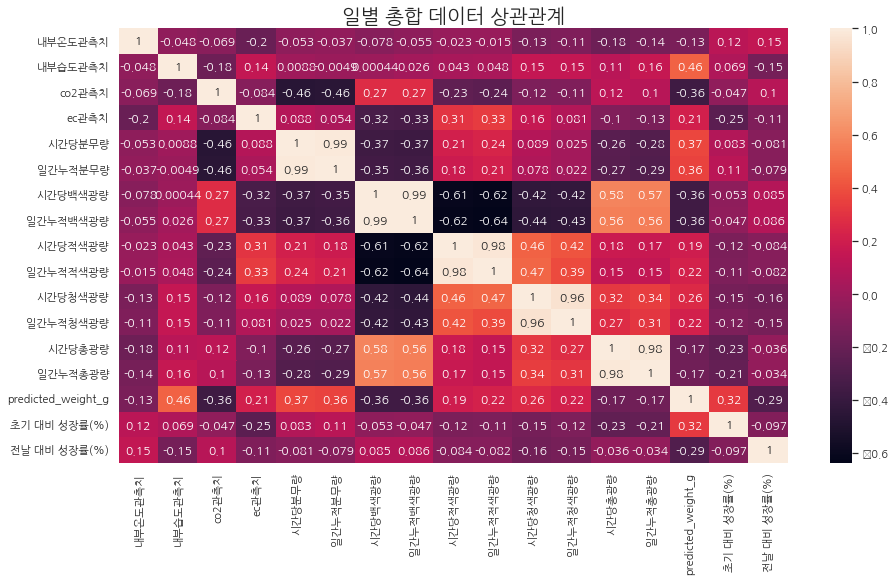

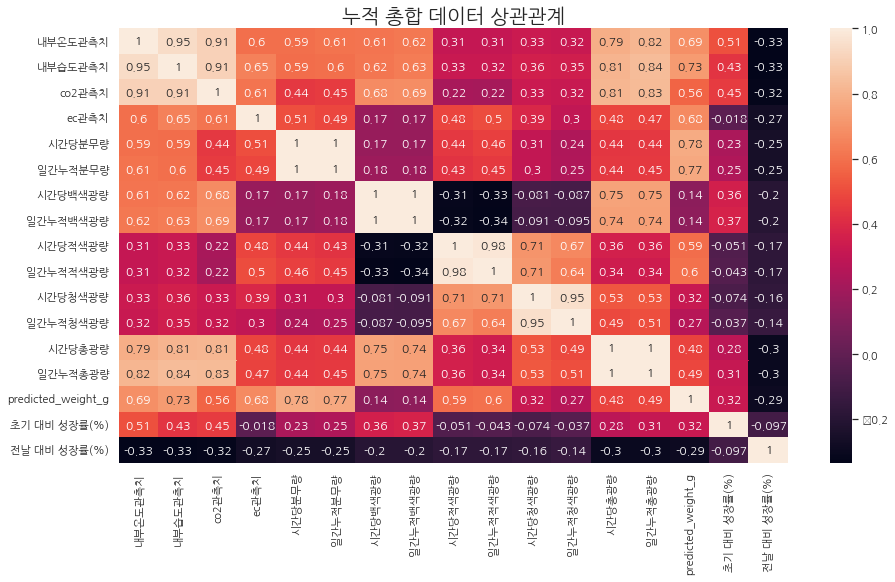

# 모델링

1. 상추의 성장을 예측하는 모델
2. 상추의 초기무게를 예측하는 모델


일단 상추의 성장을 예측하는 모델을 생각해 봤다.
1. lstm을 사용하는 모델
2. lgbm regressor를 사용하는 모델
3. CNN을 사용하는 모델..?? <br>(갑자기 든 생각인데, 1d CNN을 사용하거나 세로가 낮은 CNN을 사용해도 적절한 모델을 만들 수 있지 않을까 라는 생각이 든다.)

만약 상추의 성장률을 예측하는 모델을 만든다면 상추의 초기무게를 예측하는 모델이 필요하다.


상추의 초기무게를 예측하는 모델은 lgbm regressor이 적절할 것 같다.

**데이터 명칭 정리**
- train_daily_total_X_sd_W : 일별 총합 정규화 데이터 (무게데이터 학습에 사용됨)
- train_stacked_total_X_sd_W : 누적 총합 정규화 데이터 (무게데이터 학습에 사용됨)

**1~28일 까지의 데이터**

------------------

- train_daily_total_X_sd_R : 일별 총합 정규화 데이터 (비율데이터 학습에 사용됨)
- train_stacked_total_X_sd_R : 누적 총합 정규화 데이터 (비율데이터 학습에 사용됨)

**2~28일 까지의 데이터**

-----------------

- train_y_W : 상추 무게 데이터 (shape = 784,1)
- train_y_DGR = 전날 대비 성장 데이터(shape = 756,1)
- train_y_all.loc[:, "전날 대비 성장(g)"]

## 상추의 성장률 예측 모델

#### DNN 사용 모델
초기 5 일까지의 무게를 원래는 lgbm으로 예측했는데 성능이 조금 별론 것 같아서, 이걸로도 해보겠다.

In [ ]:
def make_day_vector(day):
    X1 = np.array(train_daily_total_X_sd_W)
    target_index = []
    for i in range(28):
        for j in range(day):
            target_index.append(j + 28*i)   
    return X1[target_index], train_y_all.iloc[target_index, 0] 

In [ ]:
X, y = make_day_vector(5)

X.shape, y.shape

((140, 15), (140,))

In [ ]:
DNN_model = keras.models.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

DNN_model.compile(loss="mse", optimizer=optimizer)

DNN_model.fit(X, y, epochs=30)

Epoch 1/30
5/5 [==============================] - 2s 5ms/step - loss: 20.3746
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 12.9779
Epoch 3/30
5/5 [==============================] - 0s 4ms/step - loss: 10.3202
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 7.1659
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 6.1184
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 7.3079
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 8.2515
Epoch 8/30
5/5 [==============================] - 0s 6ms/step - loss: 8.3427
Epoch 9/30
5/5 [==============================] - 0s 7ms/step - loss: 8.5265
Epoch 10/30
5/5 [==============================] - 0s 7ms/step - loss: 7.4466
Epoch 11/30
5/5 [==============================] - 0s 10ms/step - loss: 8.4326
Epoch 12/30
5/5 [==============================] - 0s 5ms/step - loss: 6.7829
Epoch 13/30
5/5 [==============================] - 0s 5ms/step - loss

### LSTM 사용 모델
[내가 공부한 RNN 깃허브](https://github.com/donghui-0126/machine-learning/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2%EC%9E%A5%20%EB%94%A5%EB%9F%AC%EB%8B%9D/%5B15%EC%9E%A5%5D_RNN%EA%B3%BC_CNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%B4_%EC%8B%9C%ED%80%80%EC%8A%A4_%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0.ipynb)

LSTM은 회귀를 할때 어떻게 해야하는지 잘 모르겠다. 이건 나중으로 미뤄보자

데이터 shape (28 * 28-5), 5(참고할 날짜), 14(컬럼개수)

In [ ]:
# 데이터 크기, 컬럼 수(타임스텝), 데이터 순으로 모델 크기를 재구성함

# 예측하는 날에서 4일 전까지의 데이터만 사용함. (총 5일의 데이터를 사용해서 예측)
time_step = 5 

X1 = np.array(train_daily_total_X_sd_W)

train_X1 = []

for i in range(28):
    for j in range(23):
        train_X1.append(X1[i*28+j:i*28+j+5])


train_X1 = np.array(train_X1).reshape([np.array(train_X1).shape[0], 5, -1])


X2 = np.array(train_stacked_total_X_sd_W)

train_X2 = []

for i in range(28):
    for j in range(23):
        train_X2.append(X2[i*28+j:i*28+j+5])


train_X2 = np.array(train_X2).reshape([np.array(train_X2).shape[0], 5, -1])

train_X1.shape

(644, 5, 15)

In [ ]:
train_y = []
y = np.array(train_y_all.iloc[:, 0])

for i in range(28):
    train_y.extend(y[i*28+4:i*28+27])

train_y = np.array(train_y)
train_y.shape

(644,)

#### lstm_model_1

In [ ]:
from sklearn.model_selection import KFold

sequence = 5
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0.25


early_stopping_cb = keras.callbacks.EarlyStopping(patience=8)
callbacks = [early_stopping_cb]
             
n= 1

rmse_history = []

kf = KFold(n_splits = 4)
print("학습시작")

for train_index, test_index in kf.split(range(644)):
    lstm_model1 = keras.models.Sequential([
        keras.layers.LSTM(32, return_sequences=True, input_shape=[train_X1.shape[1],train_X1.shape[2]]),
        keras.layers.LSTM(16, return_sequences=True),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(4),
        keras.layers.Dense(1)
    ])

    lstm_model1.compile(loss="mse", optimizer="adam", metrics="mse")

    lstm_model1.fit(train_X1[train_index], train_y[train_index], epochs=epoch, 
                    validation_data =(train_X1[test_index], train_y[test_index]), callbacks=callbacks, verbose=0)

    _, mse = lstm_model1.evaluate(train_X1[test_index], train_y[test_index], verbose=0)

    rmse_history.append(mse**0.5)

    print(n,"번째 fold 학습완료")
    n+=1 

print(rmse_history)
print(np.mean(rmse_history))

학습시작
1 번째 fold 학습완료
2 번째 fold 학습완료
3 번째 fold 학습완료
4 번째 fold 학습완료
[22.016194711844363, 19.486475240154547, 20.70460711086386, 18.7721597567673]
20.24485920490752


#### lstm_model_final

In [ ]:
import math 

K = keras.backend

# 지수적으로 증가하는 학습률을 사용해서 손실이 급등하는 학습률을 찾기위한 코드이다.
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
        # 배치학습이 시작될 때, 실행되는 코드
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# 모델의 학습률을 증가시키면서 손실과 학습률을 각각 받아서 리턴함
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

# 학습률과 손실의 관계를 나타내는 그래프를 설정함
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

21/21 [==============================] - 3s 7ms/step - loss: 19410.5273 - mse: 19410.5273


(9.999999747378752e-06,
 5.179472923278809,
 2053.000732421875,
 3380.4106794084823)

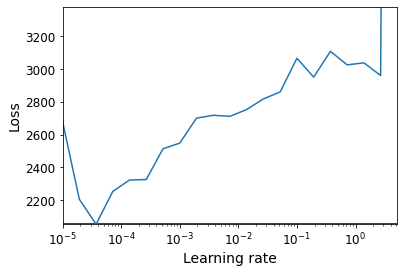

In [ ]:
sequence = 5
batch_size = 32
epoch = 90
verbose = 1
dropout_ratio = 0.25
             
lstm_model_final = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[train_X1.shape[1],train_X1.shape[2]]),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(4),
    keras.layers.Dense(1)
])

lstm_model_final.compile(loss="mse", optimizer="adam", metrics="mse")

rates, losses = find_learning_rate(lstm_model_final, train_X1, train_y, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=30)

In [ ]:
sequence = 5
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0.25

lstm_model_final = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[train_X1.shape[1],train_X1.shape[2]]),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(4),
    keras.layers.Dense(1)
])

os.chdir("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/")

model_checkpoint_cb = keras.callbacks.ModelCheckpoint("final_model.h5", monitor= "loss",save_best_only=True)
onecycle = OneCycleScheduler(len(train_X1) // batch_size * epoch, max_rate=0.0005)
lstm_model_final.compile(loss="mse", optimizer="adam", metrics="mse")

lstm_model_final.fit(train_X1, train_y, epochs=epoch,callbacks=[onecycle, early_stop_callback,model_checkpoint_cb])

Epoch 1/100
21/21 [==============================] - 3s 10ms/step - loss: 3087.9778 - mse: 3087.9778
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 3085.0315 - mse: 3085.0315
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 3083.9358 - mse: 3083.9358
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 3079.1689 - mse: 3079.1689
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 3073.0806 - mse: 3073.0806
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 3068.1965 - mse: 3068.1965
Epoch 7/100
21/21 [==============================] - 0s 9ms/step - loss: 3061.2368 - mse: 3061.2368
Epoch 8/100
21/21 [==============================] - 0s 9ms/step - loss: 3049.1650 - mse: 3049.1650
Epoch 9/100
21/21 [==============================] - 0s 9ms/step - loss: 3037.7893 - mse: 3037.7893
Epoch 10/100
21/21 [==============================] - 0s 9ms/step - loss: 3017.1631 - mse: 3017.1

### LGBM regressor 사용 모델

[내가 공부한 LGBM 깃허브 링크](https://github.com/donghui-0126/machine-learning/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%20%EC%99%84%EB%B2%BD%20%EA%B0%80%EC%9D%B4%EB%93%9C/2.%20%EB%B6%84%EB%A5%98%20%5B%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC%2C%20GBM%2C%20XGBoost%2C%20Light%20GBM%2C%20%EB%B2%A0%EC%9D%B4%EC%A7%80%EC%95%88%20%EC%B5%9C%EC%A0%81%ED%99%94%2C%20%EC%8B%A4%EC%8A%B5%2C%20%EC%8A%A4%ED%83%9C%ED%82%B9%5D.ipynb)

#### 교차 검증을 위한 인덱싱 작업

In [ ]:
index_1 = [x for x in range(28*7)]
index_2 = [x for x in range(28*7, 28*14)]
index_3 = [x for x in range(28*14, 28*21)]
index_4 = [x for x in range(28*21, 28*28)]

split_784 = [index_1, index_2, index_3, index_4]



index_11 = rate_index[:189*1]
index_22 = rate_index[189*1:189*2]
index_33 = rate_index[189*2:189*3]
index_44 = rate_index[189*3:189*4]


split_756 = [index_11, index_22, index_33, index_44]

#### lgbm_reg1 (stacked -> weight)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

rmse_history = []

kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(range(784)):


    lgbm_reg1 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg1.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg1.predict(train_stacked_total_X_sd_W.iloc[test_index]) # 예측 라벨
    rmse_history.append(mean_squared_error(y_pred, train_y_W.iloc[test_index])**0.5) # 정확도 측정 및 기록

print("각 분할의 rmse 기록 :", rmse_history)
print("평균 rmse :", np.mean(rmse_history))

각 분할의 rmse 기록 : [19.067683266628755, 17.850069247461985, 33.645259372163125, 17.13992696985662]
평균 rmse : 21.92573471402762


#### lgbm_reg2 (stacked -> growth rate)

In [ ]:
rmse_history = []
growth_index =[]

kf = KFold(n_splits = 4)

for train_index, test_index in kf.split(range(756)):
    

    lgbm_reg2 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg2.fit(train_stacked_total_X_sd_R.iloc[train_index], train_y_R.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg2.predict(train_stacked_total_X_sd_R.iloc[test_index]) # 예측 라벨
    growth_index.append(y_pred)

In [ ]:
grto5 = []

for i in range(4):
    for j in range(7):
        grto5.extend(growth_index[i][j*27:j*27+4])

real_w = []
pred_w = []

for x in range(1,29):
    CASE = str(x).zfill(2)
    real_w.extend(list(train_y_case[CASE].iloc[[0,1,2,3,4], 1]))

    pred_w.append(real_w[(x-1)*5])

    pred_w.append(pred_w[(x-1)*5] * grto5[(x-1)*4]/100 + pred_w[(x-1)*5])
    pred_w.append(pred_w[(x-1)*5+1] * grto5[(x-1)*4+1]/100 + pred_w[(x-1)*5+1])
    pred_w.append(pred_w[(x-1)*5+2] * grto5[(x-1)*4+2]/100 + pred_w[(x-1)*5+2])
    pred_w.append(pred_w[(x-1)*5+3] * grto5[(x-1)*4+2]/100 + pred_w[(x-1)*5+3])

mean_squared_error(pred_w, real_w)**0.5

5.125631308590411

#### lgbm_reg3 (daily -> weight)

In [ ]:
rmse_history = []

kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(range(784)):


    lgbm_reg3 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg3.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg3.predict(train_daily_total_X_sd_W.iloc[test_index]) # 예측 라벨
    rmse_history.append(mean_squared_error(y_pred, train_y_W.iloc[test_index])**0.5) # 정확도 측정 및 기록

print("각 분할의 rmse 기록 :", rmse_history)
print("평균 rmse :", np.mean(rmse_history))

각 분할의 rmse 기록 : [24.09317202099786, 28.083298564939955, 25.019971250938468, 14.86881462546871]
평균 rmse : 23.01631411558625


#### lgbm_reg4 (daily-> growth rate)

In [ ]:
rmse_history = []
growth_index =[]

kf = KFold(n_splits = 4)

ii = 0
for train_index, test_index in kf.split(range(756)):
    

    lgbm_reg4 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg4.fit(train_daily_total_X_sd_R.iloc[train_index], train_y_R.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg4.predict(train_daily_total_X_sd_R.iloc[test_index]) # 예측 라벨
    growth_index.append(y_pred)

In [ ]:
grto5 = []

for i in range(4):
    for j in range(7):
        grto5.extend(growth_index[i][j*27:j*27+4])

real_w = []
pred_w = []

for x in range(1,29):
    CASE = str(x).zfill(2)
    real_w.extend(list(train_y_case[CASE].iloc[[0,1,2,3,4], 1]))

    pred_w.append(real_w[(x-1)*5])

    pred_w.append(pred_w[(x-1)*5] * grto5[(x-1)*4]/100 + pred_w[(x-1)*5])
    pred_w.append(pred_w[(x-1)*5+1] * grto5[(x-1)*4+1]/100 + pred_w[(x-1)*5+1])
    pred_w.append(pred_w[(x-1)*5+2] * grto5[(x-1)*4+2]/100 + pred_w[(x-1)*5+2])
    pred_w.append(pred_w[(x-1)*5+3] * grto5[(x-1)*4+2]/100 + pred_w[(x-1)*5+3])

mean_squared_error(pred_w, real_w)**0.5

8.199468381127257

#### lgbm_reg5 (stacked -> grow weight)
첫날 데이터는 빼는게 일반화 성능에 좋을 듯 하다.
즉, 성장률 학습에 사용되는 데이터를 사용하면 된다.

In [ ]:
rmse_history = []

kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(range(756)):


    lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg5.fit(train_stacked_total_X_sd_R.iloc[train_index], train_y_G.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg5.predict(train_stacked_total_X_sd_R.iloc[test_index]) # 예측 라벨
    rmse_history.append(mean_squared_error(y_pred, train_y_G.iloc[test_index])**0.5) # 정확도 측정 및 기록

print("각 분할의 rmse 기록 :", rmse_history)
print("평균 rmse :", np.mean(rmse_history))

각 분할의 rmse 기록 : [2.644099793147542, 3.7709392559874195, 3.883503563075291, 2.7090871044498788]
평균 rmse : 3.2519074291650325


#### lgbm_reg6 (daily -> grow weight) 

첫날 데이터는 빼는게 일반화 성능에 좋을 듯 하다. <BR>
즉, 성장률 학습에 사용되는 데이터를 사용하면 된다. 

In [ ]:
rmse_history = []

kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(range(756)):


    lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg5.fit(train_daily_total_X_sd_R.iloc[train_index], train_y_G.iloc[train_index], verbose=False) 

    y_pred = lgbm_reg5.predict(train_daily_total_X_sd_R.iloc[test_index]) # 예측 라벨
    rmse_history.append(mean_squared_error(y_pred, train_y_G.iloc[test_index])**0.5) # 정확도 측정 및 기록

print("각 분할의 rmse 기록 :", rmse_history)
print("평균 rmse :", np.mean(rmse_history))

각 분할의 rmse 기록 : [3.2560554321986452, 3.997788322331404, 3.7584642461470414, 2.3769955770090125]
평균 rmse : 3.347325894421526


### 모델별 최적 예측 구간 찾기

In [ ]:
# 예측 구간 리스트 [start, end]
day_list = [[1,2], [2, 6], [6, 11], [11, 16], [16, 21], [21, 25], [25, 29]]

# 위의 예측 구간에 해당하는 데이터 프레임의 인덱스
day_list_index = []

for start, end in day_list:
    li =[]
    for i in range(28):
        for j in range(start-1, end-1):
            li.append(28*i + j)
    day_list_index.append(li)
day_list_index[0][0:7]

[0, 28, 56, 84, 112, 140, 168]

In [ ]:
rmse_list = []

In [ ]:
rmse_list1 = []

for iii, day_index in enumerate(day_list_index):
    kf_len = int(len(day_index)/4)

    rmse_history = []

    kf = KFold(n_splits = 4)

    i = 0

    for train_index, test_index in kf.split(range(784)):


        lgbm_reg1 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
        lgbm_reg1.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 
        y_pred = lgbm_reg1.predict(train_stacked_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
        rmse_history.append(mean_squared_error(y_pred, train_y_W.iloc[day_index[kf_len*i:kf_len*(i+1)]])**0.5) # 정확도 측정 및 기록

        i += 1

    print("stacked_data -> weight 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
    # print("각 분할의 rmse 기록 :", rmse_history)
    print("평균 rmse :", np.mean(rmse_history))
    rmse_list1.append(np.mean(rmse_history))
    print("\n")

stacked_data -> weight 모델 예측구간: 1일~1일
평균 rmse : 2.2961200319132353


stacked_data -> weight 모델 예측구간: 2일~5일
평균 rmse : 3.2444248507564475


stacked_data -> weight 모델 예측구간: 6일~10일
평균 rmse : 6.712857854161869


stacked_data -> weight 모델 예측구간: 11일~15일
평균 rmse : 15.835569728959939


stacked_data -> weight 모델 예측구간: 16일~20일
평균 rmse : 25.563034410743164


stacked_data -> weight 모델 예측구간: 21일~24일
평균 rmse : 29.746054700834783


stacked_data -> weight 모델 예측구간: 25일~28일
평균 rmse : 34.467620221970286




In [ ]:
rmse_list2= []

for iii, day_index in enumerate(day_list_index):
    kf_len = int(len(day_index)/4)

    rmse_history = []

    kf = KFold(n_splits = 4)

    i = 0

    for train_index, test_index in kf.split(range(784)):


        lgbm_reg3 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
        lgbm_reg3.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 
        y_pred = lgbm_reg3.predict(train_daily_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
        rmse_history.append(mean_squared_error(y_pred, train_y_W.iloc[day_index[kf_len*i:kf_len*(i+1)]])**0.5) # 정확도 측정 및 기록

        i += 1

    print("stacked_data -> weight 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
    # print("각 분할의 rmse 기록 :", rmse_history)
    print("평균 rmse :", np.mean(rmse_history))
    rmse_list2.append(np.mean(rmse_history))
    print("\n")

stacked_data -> weight 모델 예측구간: 1일~1일
평균 rmse : 7.860458829616386


stacked_data -> weight 모델 예측구간: 2일~5일
평균 rmse : 8.560680895418876


stacked_data -> weight 모델 예측구간: 6일~10일
평균 rmse : 8.872985614687984


stacked_data -> weight 모델 예측구간: 11일~15일
평균 rmse : 11.565357602072842


stacked_data -> weight 모델 예측구간: 16일~20일
평균 rmse : 25.406179898930326


stacked_data -> weight 모델 예측구간: 21일~24일
평균 rmse : 35.51579050736723


stacked_data -> weight 모델 예측구간: 25일~28일
평균 rmse : 35.032043499191474




In [ ]:
rmse_list3 = [None]

for iii, day_index in enumerate(day_list_index):
    if iii != 0:
        kf_len = int(len(day_index)/4)

        rmse_history = []

        kf = KFold(n_splits = 4)

        i = 0

        for train_index, test_index in kf.split(range(784)):


            lgbm_reg2 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
            lgbm_reg2.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,2], verbose=False) 
            y_pred = lgbm_reg2.predict(train_stacked_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
            rmse_history.append(mean_squared_error(y_pred, train_y_all.iloc[day_index[kf_len*i:kf_len*(i+1)],2])**0.5) # 정확도 측정 및 기록

            i += 1

        print("stacked_data -> growth rate 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
        # print("각 분할의 rmse 기록 :", rmse_history)
        print("평균 rmse :", np.mean(rmse_history))
        rmse_list3.append(np.mean(rmse_history))

        print("\n")

stacked_data -> growth rate 모델 예측구간: 2일~5일
평균 rmse : 87.25314008773628


stacked_data -> growth rate 모델 예측구간: 6일~10일
평균 rmse : 34.27821432100564


stacked_data -> growth rate 모델 예측구간: 11일~15일
평균 rmse : 12.525722350164251


stacked_data -> growth rate 모델 예측구간: 16일~20일
평균 rmse : 12.287068170889004


stacked_data -> growth rate 모델 예측구간: 21일~24일
평균 rmse : 10.828683407005155


stacked_data -> growth rate 모델 예측구간: 25일~28일
평균 rmse : 9.479867275958062




In [ ]:
rmse_list4 = [None]


for iii, day_index in enumerate(day_list_index):
    if iii != 0:
        kf_len = int(len(day_index)/4)

        rmse_history = []

        kf = KFold(n_splits = 4)

        i = 0

        for train_index, test_index in kf.split(range(784)):


            lgbm_reg4 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
            lgbm_reg4.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,2], verbose=False) 
            y_pred = lgbm_reg4.predict(train_daily_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
            rmse_history.append(mean_squared_error(y_pred, train_y_all.iloc[day_index[kf_len*i:kf_len*(i+1)],2])**0.5) # 정확도 측정 및 기록

            i += 1

        print("daily_data -> growth rate 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
        # print("각 분할의 rmse 기록 :", rmse_history)
        print("평균 rmse :", np.mean(rmse_history))
        rmse_list4.append(np.mean(rmse_history))

        print("\n")

daily_data -> growth rate 모델 예측구간: 2일~5일
평균 rmse : 84.3430127596094


daily_data -> growth rate 모델 예측구간: 6일~10일
평균 rmse : 40.532759304718155


daily_data -> growth rate 모델 예측구간: 11일~15일
평균 rmse : 25.589985912202387


daily_data -> growth rate 모델 예측구간: 16일~20일
평균 rmse : 23.430458974874412


daily_data -> growth rate 모델 예측구간: 21일~24일
평균 rmse : 21.4711095462414


daily_data -> growth rate 모델 예측구간: 25일~28일
평균 rmse : 20.095950436922763




In [ ]:
rmse_list5= []

for iii, day_index in enumerate(day_list_index):
    kf_len = int(len(day_index)/4)

    rmse_history = []

    kf = KFold(n_splits = 4)

    i = 0

    for train_index, test_index in kf.split(range(784)):


        lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
        lgbm_reg5.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,3], verbose=False) 
        y_pred = lgbm_reg5.predict(train_stacked_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
        rmse_history.append(mean_squared_error(y_pred, train_y_all.iloc[day_index[kf_len*i:kf_len*(i+1)],3])**0.5) # 정확도 측정 및 기록

        i += 1

    print("stacked_data -> growth weight 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
    # print("각 분할의 rmse 기록 :", rmse_history)
    print("평균 rmse :", np.mean(rmse_history))
    rmse_list5.append(np.mean(rmse_history))
    print("\n")

stacked_data -> growth weight 모델 예측구간: 1일~1일
평균 rmse : 2.2687335639611175


stacked_data -> growth weight 모델 예측구간: 2일~5일
평균 rmse : 0.873505392329125


stacked_data -> growth weight 모델 예측구간: 6일~10일
평균 rmse : 1.5055548125595757


stacked_data -> growth weight 모델 예측구간: 11일~15일
평균 rmse : 2.6687648546872857


stacked_data -> growth weight 모델 예측구간: 16일~20일
평균 rmse : 3.870097313018274


stacked_data -> growth weight 모델 예측구간: 21일~24일
평균 rmse : 4.139212551786929


stacked_data -> growth weight 모델 예측구간: 25일~28일
평균 rmse : 4.866978446184476




In [ ]:
rmse_list6 = []

for iii, day_index in enumerate(day_list_index):
    kf_len = int(len(day_index)/4)

    rmse_history = []

    kf = KFold(n_splits = 4)

    i = 0

    for train_index, test_index in kf.split(range(784)):


        lgbm_reg6 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
        lgbm_reg6.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,3], verbose=False) 
        y_pred = lgbm_reg6.predict(train_daily_total_X_sd_W.iloc[day_index[kf_len*i:kf_len*(i+1)]]) # 예측 라벨
        rmse_history.append(mean_squared_error(y_pred, train_y_all.iloc[day_index[kf_len*i:kf_len*(i+1)],3])**0.5) # 정확도 측정 및 기록

        i += 1

    print("daily_data -> growth weight 모델 예측구간: {}일~{}일".format(day_list[iii][0], day_list[iii][1]-1))
    # print("각 분할의 rmse 기록 :", rmse_history)
    print("평균 rmse :", np.mean(rmse_history))
    rmse_list6.append(np.mean(rmse_history))

    print("\n")

daily_data -> growth weight 모델 예측구간: 1일~1일
평균 rmse : 2.1458307309655367


daily_data -> growth weight 모델 예측구간: 2일~5일
평균 rmse : 1.3626966365973083


daily_data -> growth weight 모델 예측구간: 6일~10일
평균 rmse : 1.4431963058939028


daily_data -> growth weight 모델 예측구간: 11일~15일
평균 rmse : 2.4247967085962983


daily_data -> growth weight 모델 예측구간: 16일~20일
평균 rmse : 3.65404958631147


daily_data -> growth weight 모델 예측구간: 21일~24일
평균 rmse : 4.360808109224952


daily_data -> growth weight 모델 예측구간: 25일~28일
평균 rmse : 4.998913271699825




In [ ]:
rmse_list = [rmse_list1, rmse_list2, rmse_list3, rmse_list4, rmse_list5, rmse_list6]

model_valid = pd.DataFrame(rmse_list, 
             index=["stacked_data -> weight", "daily_data -> weight", "stacked_data -> growth rate", 
                    "daily_data -> growth rate", "stacked_data -> growth weight", "daily_data -> growth weight"] , 
             columns=["Day 1", "Day 2~5", "Day 6~10", "Day 11~15", "Day 16~20","Day 21~25", "Day 25~28"])

model_valid

,Day 1,Day 2~5,Day 6~10,Day 11~15,Day 16~20,Day 21~25,Day 25~28
stacked_data -> weight,2.296120,3.244425,6.712858,15.835570,25.563034,29.746055,34.467620
daily_data -> weight,7.860459,8.560681,8.872986,11.565358,25.406180,35.515791,35.032043
stacked_data -> growth rate,NaN,87.253140,34.278214,12.525722,12.287068,10.828683,9.479867
daily_data -> growth rate,NaN,84.343013,40.532759,25.589986,23.430459,21.471110,20.095950
stacked_data -> growth weight,2.268734,0.873505,1.505555,2.668765,3.870097,4.139213,4.866978
daily_data -> growth weight,2.145831,1.362697,1.443196,2.424797,3.654050,4.360808,4.998913


위 모델별 최적 구간을 살펴보겠다.

예측하는 데이터에 따라서 단위가 다르기 때문에 고려를 해야서 최적의 모델을 구하면 될듯 하다. 

1일차는 가장 오차가 적은 daily_data-> grow weight 모델로 정하고 나머지 기간들은 각 기간별로 같은 것을 예측하는 모델중더 오차가 적은 모델로 정하면 될듯 하다. 

1x3x3x3x3x3x3 = 729 가지의 모델로 실험을 해보면 될 듯 하다. 

## 모델 실험

0. 타겟데이터마다 일별로 자를 수 있는 함수 만들기. rmse 측정을 위함.<br>
    list.extend를 사용해서 한개의 벡터를 만든다.



1. 각 케이스를 제외한 인덱스 리스트 만들기.<br>
index_list = [ ] <br>
    ex) index_list[1] = 1번째 케이스 상추를 제외한 인덱스. 



2. 케이스 마다 케이스를 제외한 데이터를 학습하는 모델을 만들기. (lgbm1~6 모델 학습) <br>
28 x 6 개의 모델을 학습함. <br>
pred_case_model = [ ][ ] <br>
    ex) pred_case_model[1][1]= 1번째 케이스 상추를 제외한 데이터로 학습한 lgbm_reg1 모델



3. 위 모델들로 각 예측을 리스트로 만들기.<br>
pred_case_model_day= [ ] [ ] [ ]<br> 
    ex)pred_case_model_day[1][1][1] = 1번째 케이스 상추를 제외한 데이터로 학습한 lgbm_reg1 모델의 첫째날 예측



4. 2에서 구한 예측들을 토대로 최종 무게 예측 데이터를 만듦. 
    <b>
day_list = [[1,2], [2, 6], [6, 11], [11, 16], [16, 21], [21, 25], [25, 29]</b><br>
    를 참고해서 만들면 될듯 함. for문 사용.

    - weight 추정 데이터를 최종 무게 예측 데이터로 만드는 함수
    - 성장률 추정 데이터를 최종 무게 예측 데이터로 만드는 함수
    - growth_weight 추정 데이터를 최종 무게 예측 데이터로 만드는 함수



5. 0. 에서 만든 타겟 데이터와 4. 에서 만든 데이터의 rmse를 한번에 비교함.<br>
list.extend 를 사용해서 한개의 벡터를 만든다.<br>
final_pred = [ ]

In [ ]:
'''
0. 타겟데이터마다 일별로 자를 수 있는 함수 만들기. rmse 측정을 위함.
'''

def make_target_vector(day):
    target_index = []
    for i in range(28):
        for j in range(day):
            target_index.append(j + 28*i)   
    return train_y_all.iloc[target_index, 0] 

In [ ]:
def make_list(test_index):
    test_len = int(len(test_index)/7)
    list_1 = test_index[:test_len]
    list_2 = test_index[test_len:test_len*2]
    list_3 = test_index[test_len*2:test_len*3]
    list_4 = test_index[test_len*3:test_len*4]
    list_5 = test_index[test_len*4:test_len*5]
    list_6 = test_index[test_len*5:test_len*6]
    list_7 = test_index[test_len*6:test_len*7]

    return list_1,list_2,list_3,list_4,list_5,list_6,list_7

In [ ]:
kf = KFold(n_splits=4)

fold=1 
all_pred = []

for train_index, test_index in kf.split(range(784)):
    print(fold, "번째 fold")
    # 모델 학습 시키기
    lgbm_reg1 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg1.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 

    lgbm_reg2 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg2.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,2], verbose=False) 

    lgbm_reg3 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg3.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_W.iloc[train_index], verbose=False) 

    lgbm_reg4 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg4.fit(train_daily_total_X_sd_W.iloc[train_index],train_y_all.iloc[train_index,2], verbose=False) 

    lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg5.fit(train_stacked_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,3], verbose=False) 

    lgbm_reg6 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg6.fit(train_daily_total_X_sd_W.iloc[train_index], train_y_all.iloc[train_index,3], verbose=False) 

    # pred 변수
    pred=  [None, [], [], [], [], [], [], []]

    # 테스트 데이터 보기쉽게 나누기
    test_data = train_daily_total_X_sd_W.iloc[test_index]
    list_1,list_2,list_3,list_4,list_5,list_6,list_7 = make_list(test_index)

    test_data_daily = [None, train_daily_total_X_sd_W.iloc[list_1], train_daily_total_X_sd_W.iloc[list_2], train_daily_total_X_sd_W.iloc[list_3], 
                 train_daily_total_X_sd_W.iloc[list_4], train_daily_total_X_sd_W.iloc[list_5], train_daily_total_X_sd_W.iloc[list_6], train_daily_total_X_sd_W.iloc[list_7]]

    test_data_stacked = [None, train_stacked_total_X_sd_W.iloc[list_1], train_stacked_total_X_sd_W.iloc[list_2], train_stacked_total_X_sd_W.iloc[list_3], 
                 train_stacked_total_X_sd_W.iloc[list_4], train_stacked_total_X_sd_W.iloc[list_5], train_stacked_total_X_sd_W.iloc[list_6], train_stacked_total_X_sd_W.iloc[list_7]]

    
    ####################################
    # 초기 무게 예측 (lgbm6: daily-> growth weight) | rmse = 2.145831
    for i in range(1, 8):
        initial_pred = abs(lgbm_reg6.predict(test_data_daily[i])[0])
        pred[i].append(initial_pred)

    ####################################
    # 2~5일 무게예측
    '''
    # 1. lgbm1: stacked_data -> weight | rmse:  3.490668986009254
    
    for i in range(1, 8):
        li = list(lgbm_reg1.predict(test_data_stacked[i])[1:5])
        pred[i].extend(li)
    
    # 2. lgbm_3: daily_data -> growth rate | rmse: 4.361826783222147

    for i in range(1, 8):
        li = list(lgbm_reg4.predict(test_data_daily[i])[1:5])
        li2 = [pred[i][-1]*(li[0]/100+1)]
        li2.append(li2[0] * (li[1]/100+1))
        li2.append(li2[1] * (li[2]/100+1))
        li2.append(li2[2] * (li[3]/100+1))
        pred[i].extend(li2)
    '''
    # 3. lgbm_reg5 (stacked -> grow weight) | 3.1422712262903154
    # lgbm_5 모델이 선택됨.

    for i in range(1, 8):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[1:5])     
        li2 = [pred[i][0] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])

        pred[i].extend(li2)
    
    ####################################
    # 6~10일 무게예측
    '''
    # # 1. lgbm1: stacked_data -> weight | rmse: 5.698081858443776
    for i in range(1, 8):
        li = list(lgbm_reg1.predict(test_data_stacked[i])[5:10])
        pred[i].extend(li)

    # 2. lgbm2: stacked_data -> growth rate |rmse:  9.026787652875939
    for i in range(1, 8):
        li = list(lgbm_reg2.predict(test_data_stacked[i])[5:10])
        li2 = [pred[i][-1]*(li[0]/100+1)]
        li2.append(li2[0] * (li[1]/100+1))
        li2.append(li2[1] * (li[2]/100+1))
        li2.append(li2[2] * (li[3]/100+1))
        li2.append(li2[3] * (li[4]/100+1))
        pred[i].extend(li2)
    '''
    # 3. lgbm_6: daily_data -> growth weight | 5.480477965592783
    # lgbm_6 모델이 선택됨.
    for i in range(1, 8):
        li = list(lgbm_reg6.predict(test_data_daily[i])[5:10])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)
    
    ####################################
    # 11~15일 무게예측
    '''
    # 1. lgbm_reg1 (stacked -> weight) | rmse: 10.96585880466057
    for i in range(1, 8):
        li = list(lgbm_reg1.predict(test_data_stacked[i])[10:15])
        pred[i].extend(li)
    
    # 2. lgbm_reg2 (stacked -> growth rate) | rmse: 12.367346477866556
    for i in range(1, 8):
        li = list(lgbm_reg2.predict(test_data_stacked[i])[10:15])
        li2 = [pred[i][-1]*(li[0]/100+1)]
        li2.append(li2[0] * (li[1]/100+1))
        li2.append(li2[1] * (li[2]/100+1))
        li2.append(li2[2] * (li[3]/100+1))
        li2.append(li2[3] * (li[4]/100+1))
        pred[i].extend(li2)
    '''
    # 3. lgbm_reg6 (daily -> grow weight) | rmse: 8.858352673010751
    for i in range(1, 8):
        li = list(lgbm_reg6.predict(test_data_daily[i])[10:15])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)


    ####################################
    # 16~20일 무게예측
    '''
    # 1. lgbm_reg3 (daily -> weight) | rmse: 15.237585422915325
    for i in range(1, 8):
        li = list(lgbm_reg3.predict(test_data_daily[i])[15:20])
        pred[i].extend(li)
    
    # 2. lgbm_reg2 (stacked -> growth rate) | rmse: 15.315663865895681
    for i in range(1, 8):
        li = list(lgbm_reg2.predict(test_data_stacked[i])[15:20])
        li2 = [pred[i][-1]*(li[0]/100+1)]
        li2.append(li2[0] * (li[1]/100+1))
        li2.append(li2[1] * (li[2]/100+1))
        li2.append(li2[2] * (li[3]/100+1))
        li2.append(li2[3] * (li[4]/100+1))
        pred[i].extend(li2)
    '''
    # 3. lgbm_reg6 (daily -> grow weight) | rmse: 13.942179211077281
    for i in range(1, 8):
        li = list(lgbm_reg6.predict(test_data_daily[i])[15:20])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)

    ####################################
    # 21~25일 무게예측
    '''
    # 1. lgbm_reg1 (stacked -> weight) | rmse: 22.378775685996853
    for i in range(1, 8):
        li = list(lgbm_reg3.predict(test_data_stacked[i])[20:25])
        pred[i].extend(li)
    
    # 2. lgbm_reg2 (stacked -> growth rate) | rmse: 22.470400713213273
    for i in range(1, 8):
        li = list(lgbm_reg2.predict(test_data_stacked[i])[20:25])
        li2 = [pred[i][-1]*(li[0]/100+1)]
        li2.append(li2[0] * (li[1]/100+1))
        li2.append(li2[1] * (li[2]/100+1))
        li2.append(li2[2] * (li[3]/100+1))
        li2.append(li2[3] * (li[4]/100+1))
        pred[i].extend(li2)
    '''
    # 3. lgbm_reg5 (stacked -> grow weight) | rmse: 18.6669196066826
    for i in range(1, 8):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[20:25])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])
        pred[i].extend(li2)

    ####################################
    # # 25~28일 무게예측
    """
    # # 1. lgbm_reg1 (stacked -> weight) | rmse: 23.032173394833755
    # for i in range(1, 8):
    #     li = list(lgbm_reg3.predict(test_data_stacked[i])[25:28])
    #     pred[i].extend(li)
    """
    # # # 2. lgbm_reg2 (stacked -> growth rate) | rmse: 23.705896004601655
    # for i in range(1, 8):
    #     li = list(lgbm_reg2.predict(test_data_stacked[i])[25:28])
    #     li2 = [pred[i][-1]*(li[0]/100+1)]
    #     li2.append(li2[0] * (li[1]/100+1))
    #     li2.append(li2[1] * (li[2]/100+1))
    #     pred[i].extend(li2)
    

    # 3. lgbm_reg5 (stacked -> grow weight) | rmse: 22.701096506434375
    for i in range(1, 8):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[25:28])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        pred[i].extend(li2)





    # pred 통합
    for i in range(1, 8):
        all_pred.extend(pred[i])

    print(fold*7, "/", 28)
    
    fold+=1 

print("rmse:", mean_squared_error(make_target_vector(28), all_pred)**0.5)

1 번째 fold
7 / 28
2 번째 fold
14 / 28
3 번째 fold
21 / 28
4 번째 fold
28 / 28
rmse: 22.701096506434375


lgbm_reg6-> lgbm_reg5 -> lgbm_reg6 -> lgbm_reg6 -> lgbm_reg5 -> lgbm_reg5

### CNN 사용모델 (폐기)
[내가 공부한 CNN 깃허브 링크](https://github.com/donghui-0126/machine-learning/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2%EC%9E%A5%20%EB%94%A5%EB%9F%AC%EB%8B%9D/%5B14%EC%9E%A5%5D_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84.ipynb)

In [ ]:
CNN_data = []

for CASE in range(1,29):
    for DAY in range(28):
        scaler = StandardScaler()
        data = scaler.fit_transform((train_X_case_day[CASE][DAY].drop("obs_time", axis=1)))
        CNN_data.append(data)

CNN_data = np.array(CNN_data)

In [ ]:
CNN_data.shape

(784, 24, 15)

In [ ]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv1D(32, 8, activation="relu", padding="valid",),

    keras.layers.Conv1D(16, 4, activation="relu", padding="valid"),

    keras.layers.Conv1D(8, 4, activation="relu", padding="valid"),

    keras.layers.Flatten(),

    keras.layers.Dense(64),

    keras.layers.Dense(8),

    keras.layers.Dense(1, activation="relu")
])

cnn_model.compile(loss="mse", optimizer="adam")

# cnn_model.fit(CNN_data, train_y_all, epochs=20)

# test 데이터 가공
- 데이터셋 합치기/지우기 (28일차 데이터 삭제)
- target데이터 가공
- noise 데이터 처리
- stacked데이터 만들기
- 데이터 표준화

## 테스트 데이터셋 적재 test_X_case, test_y_case (dict)

In [ ]:
test_X_case = {}

for i in range(1, 6):
    test_X_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/test_input/TEST_{}.csv".format(str(i).zfill(2)))
 

In [ ]:
test_y_case = {}

for i in range(1, 6):
    test_y_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/test_target/TEST_{}.csv".format(str(i).zfill(2)))
 

## 테스트 데이터 나누기

In [ ]:
test_X_case_day = [[]]

for i in range(1,6):
    test_X_case_day.append([])
    for j in range(1,29):
        test_X_case_day[i].append(test_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

## test 노이즈값 처리
- 광량이 음수인경우 -> 이전과 이후데이터의 평균을 넣어준다.
- 온도가 0인 경우 -> 이전과 이후데이터의 평균을 넣어준다.
- 시간당 분무량이 음수인 경우 -> 이전과 이후데이터의 평균을 넣어준다.
- 내부 습도가 0인 경우 -> 이전과 이후데이터의 평균을 넣어준다.
- 나머지 컬럼이 음수인 경우-> 평균값으로 채워준다.

In [ ]:
control_variable = pd.DataFrame()

noise = [[]]

for i in range(1, 6):
    noise.append([])
    CASE = str(i).zfill(2)

    # 내부 온도 관측치가 0인 경우
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[2]]<=0].index)    

    # 내부습도 관측치가 0인 경우
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[3]]<=0].index)    

    # co2 관측치
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[4]]<=0].index)    

    # 시간당 분무량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[6]]<0].index)    

    # 누적 분무량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[7]]<0].index)    

    # 시간당 백색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[8]]<0].index)    

    # 일간 누적 백색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[9]]<0].index)    

    # 시간당 적색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[10]]<0].index)    

    # 일간 누적 적색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[11]]<0].index)    

    # 시간당 청색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[12]]<0].index)    

    # 일간 누적 청색광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[13]]<0].index)    

    # 시간당 총광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[14]]<0].index)    

    # 일간 누적 총광량
    noise[i].append(test_X_case[CASE][test_X_case[CASE][col[15]]<0].index)    


In [ ]:
for i in range(1, 6):
    for j in range(13):
        if len(noise[i][j]) != 0 and len(noise[i][j])<100:
            print("case{} {}".format(i, col[j//2+2]))
            print(noise[i][j], "\n")

 noise값이 없다.

## 테스트 데이터 null값 처리

In [ ]:
for i in range(1, 6):
    CASE = str(i).zfill(2)
    for _ in test_X_case[CASE].isnull().sum():
        if _ == True:
            print(_)

null값이 없다.

## 테스트 데이터를 일별 데이터로 가공

### 일별 총합 데이터

In [ ]:
# 하루의 총합으로 일별데이터 가공을 진행했다.

test_daily_total_X =  pd.DataFrame()

for CASE in range(1,6):
    for DAY in range(0,28):
        # series를 전치시켜서 내가 원하는 데이터프레임을 얻음.
        total = pd.DataFrame(test_X_case_day[CASE][DAY].sum()).T.drop(["obs_time"], axis=1)
        test_daily_total_X = test_daily_total_X.append(total, ignore_index=True)

In [ ]:
test_daily_total_X.shape

(140, 15)

### 누적 총합 데이터

In [ ]:
test_stacked_total_X = pd.DataFrame()

for CASE in range(1,6):
    for DAY in range(0,28):
        stacked_total = test_daily_total_X.iloc[(CASE-1)*28:DAY+(CASE-1)*28+1 ,:].sum()
        test_stacked_total_X = test_stacked_total_X.append(stacked_total, ignore_index=True)

In [ ]:
test_stacked_total_X.shape

(140, 15)

## 테스트 데이터 정규화

### 테스트 누적 총합 데이터 정규화

In [ ]:
# standardized
test_stacked_total_X_sd = pd.DataFrame(train_stacked_total_scaler.fit_transform(test_stacked_total_X), columns=test_stacked_total_X.columns)
test_stacked_total_X_sd.columns = test_stacked_total_X.columns

### 테스트 일별 총합데이터 정규화

In [ ]:
# standardized
test_daily_total_X_sd = pd.DataFrame(train_daily_total_scaler.fit_transform(test_daily_total_X), columns=test_daily_total_X.columns)
test_daily_total_X_sd.columns = test_daily_total_X.columns

## 데이터셋 타입 변경 to float32

In [ ]:
# float32 로 타입 변경
test_daily_total_X_sd = test_daily_total_X_sd.astype(np.float32)
test_stacked_total_X_sd = test_stacked_total_X_sd.astype(np.float32)

In [ ]:
# 데이터 크기, 컬럼 수(타임스텝), 데이터 순으로 모델 크기를 재구성함

# 예측하는 날에서 4일 전까지의 데이터만 사용함. (총 5일의 데이터를 사용해서 예측)
time_step = 5 

X11 = np.array(train_daily_total_X_sd_W)

test_X1 = []

for i in range(5):
    for j in range(23):
        test_X1.append(X11[i*28+j:i*28+j+5])


test_X1 = np.array(test_X1).reshape([np.array(test_X1).shape[0], 5, -1])


X22 = np.array(train_stacked_total_X_sd_W)

test_X2 = []

for i in range(5):
    for j in range(23):
        test_X2.append(X22[i*28+j:i*28+j+5])


test_X2 = np.array(test_X2).reshape([np.array(test_X2).shape[0], 5, -1])

test_X1.shape

(115, 5, 15)

# 모델 예측

#### lgbm 모델 예측

In [ ]:
# lgbm 모델을 사용한 예측

for _ in range(1):
    lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg5.fit(train_stacked_total_X_sd_W, train_y_all.iloc[:,3], verbose=False) 

    lgbm_reg6 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
    lgbm_reg6.fit(train_daily_total_X_sd_W, train_y_all.iloc[:,3], verbose=False) 

    # pred 변수
    pred=  [None, [], [], [], [], []]

    test_data_daily = [None, test_daily_total_X_sd.iloc[:28], test_daily_total_X_sd.iloc[28:56], test_daily_total_X_sd.iloc[56:84], 
                 test_daily_total_X_sd.iloc[84:112], test_daily_total_X_sd.iloc[112:140]]    
    test_data_stacked = [None, test_stacked_total_X_sd.iloc[:28], test_stacked_total_X_sd.iloc[28:56], test_stacked_total_X_sd.iloc[56:84], 
                 test_stacked_total_X_sd.iloc[84:112], test_stacked_total_X_sd.iloc[112:140]]

    
    ####################################
    # 초기 무게 예측 (lgbm6: daily-> growth weight) | rmse = 2.145831
    for i in range(1, 6):
        initial_pred = abs(lgbm_reg6.predict(test_data_daily[i])[0])
        pred[i].append(initial_pred)

    ####################################
    # 2~5일 무게예측

    # 3. lgbm_reg5 (stacked -> grow weight) | 3.1422712262903154
    # lgbm_5 모델이 선택됨.

    for i in range(1, 6):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[1:5])     
        li2 = [pred[i][0] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])

        pred[i].extend(li2)
    
    ####################################
    # 6~10일 무게예측
    # 3. lgbm_6: daily_data -> growth weight | 5.480477965592783
    # lgbm_6 모델이 선택됨.
    for i in range(1, 6):
        li = list(lgbm_reg6.predict(test_data_daily[i])[5:10])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)
    
    ####################################
    # 11~15일 무게예측
    # 3. lgbm_reg6 (daily -> grow weight) | rmse: 8.858352673010751
    for i in range(1, 6):
        li = list(lgbm_reg6.predict(test_data_daily[i])[10:15])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)


    ####################################
    # 16~20일 무게예측
    # 3. lgbm_reg6 (daily -> grow weight) | rmse: 13.942179211077281
    for i in range(1, 6):
        li = list(lgbm_reg6.predict(test_data_daily[i])[15:20])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])

        pred[i].extend(li2)

    ####################################
    # 21~25일 무게예측
    # 3. lgbm_reg5 (stacked -> grow weight) | rmse: 18.6669196066826
    for i in range(1, 6):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[20:25])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        li2.append(li2[2] + li[3])
        li2.append(li2[3] + li[4])
        pred[i].extend(li2)

    ####################################
    # # 25~28일 무게예측
    # 3. lgbm_reg5 (stacked -> grow weight) | rmse: 22.701096506434375
    for i in range(1, 6):
        li = list(lgbm_reg5.predict(test_data_stacked[i])[25:28])     
        li2 = [pred[i][-1] + li[0]]
        li2.append(li2[0] + li[1])
        li2.append(li2[1] + li[2])
        pred[i].extend(li2)

    # pred 통합
    all_pred = []

    for i in range(1, 6):
        all_pred.extend(pred[i])

#### lstm 모델 예측

In [ ]:
# lstm 모델을 사용한 예측
lgbm_reg5 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
lgbm_reg5.fit(train_stacked_total_X_sd_W, train_y_all.iloc[:,3], verbose=False)

lgbm_reg6 = LGBMRegressor(n_estimators=300, learning_rate=0.1, loss="rmse",colsample_bytree=0.5)
lgbm_reg6.fit(train_daily_total_X_sd_W, train_y_all.iloc[:,3], verbose=False) 

# pred 변수
pred=  [None, [], [], [], [], []]

test_data_daily = [None, test_daily_total_X_sd.iloc[:28], test_daily_total_X_sd.iloc[28:56], test_daily_total_X_sd.iloc[56:84], 
                 test_daily_total_X_sd.iloc[84:112], test_daily_total_X_sd.iloc[112:140]]    
test_data_stacked = [None, test_stacked_total_X_sd.iloc[:28], test_stacked_total_X_sd.iloc[28:56], test_stacked_total_X_sd.iloc[56:84], 
                 test_stacked_total_X_sd.iloc[84:112], test_stacked_total_X_sd.iloc[112:140]]


os.chdir("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회")


for i in range(1,6):
    pred[i].extend(list(DNN_model.predict(test_data_daily[i])[:5]))


lstm_model_final = keras.models.load_model("final_model.h5")

pred5to28 = lstm_model_final.predict(test_X1)


for i in range(1,6):
    pred[i].extend(pred5to28[23*(i-1):23*i])

# pred 통합
all_pred = []

for i in range(1, 6):
    all_pred.extend(pred[i])

4/4 [==============================] - 1s 6ms/step


In [ ]:
p = []
for x in all_pred:
    p.append(float(x))

In [ ]:
pred1 = p[0:28]
pred2 = p[28:56]
pred3 = p[56:84]
pred4 = p[84:112]
pred5 = p[112:140]

In [ ]:
sub_1 = pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/sample_submission/TEST_01.csv")
sub_2 = pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/sample_submission/TEST_02.csv")
sub_3 = pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/sample_submission/TEST_03.csv")
sub_4 = pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/sample_submission/TEST_04.csv")
sub_5 = pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/sample_submission/TEST_05.csv")

In [ ]:
sub_1.loc[:, "predicted_weight_g"] = pred1
sub_2.loc[:, "predicted_weight_g"] = pred2
sub_3.loc[:, "predicted_weight_g"] = pred3
sub_4.loc[:, "predicted_weight_g"] = pred4
sub_5.loc[:, "predicted_weight_g"] = pred5

In [ ]:
sub_1.to_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/TEST_01.csv", index = False)
sub_2.to_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/TEST_02.csv", index = False)
sub_3.to_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/TEST_03.csv", index = False)
sub_4.to_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/TEST_04.csv", index = False)
sub_5.to_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/TEST_05.csv", index = False)

In [ ]:
import zipfile

os.chdir("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/submission4/")

file_ls = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']

with zipfile.ZipFile("submission_zip.zip", 'w') as my_zip:
    for i in file_ls:
        my_zip.write(i)
    my_zip.close()

# 방명록


####12/5 5일차

내가 지금까지 엄청나게 잘못생각한 것 같다. 생장률을 구하면 초기 무게를 구하지 못하고, 일당 면적을 구하려고 하면 성장에 대한 추이를 학습할 수 없다. (과대적합은 덤이다). <br>
또, 데이터셋도 잘못 설정했다. 괜히 한칸씩 앞으로 땡겼다. 

내일은 LSTM과 CNN모델을 실험 해볼 예정이다. <br>
LSTM은 데이터셋 모양을 다르게해보고 CNN은 2dconv로 데이터를 분석해보려고 한다. 

test데이터를 int타입으로 변환하는 대참사를 저질러서 엄청 헤맸는데, 내일 예측을 진행할떄는 예측이 잘 나오기를 바라는 바다.


한가지 의문이 든다. lgbm으로 무게를 학습한 모델이 가장 성능이 좋은데, 완전히 전날의 X컬럼에만 의존하기 떄문에 전날 보다 무게가 적을 수도 있을 것 같다. (즉 성장률을 반영 못한다). 전날 대비 성장률과 예상 무게를 동시에 반영해서 예측하는 모델을 만들수는 없을까?


- 데이터 셋에 DAT컬럼을 내가 추가하면 될 듯 하다!!!!! 내일 해보자. 




++ 초기 대비 성장률은 폐기했다.

#### 12/6 6일차

~~어제 오류를 수정한 코드를 통해서 예측을 얻었다. 근데 제출할 때마다 에러가 뜬다... 으악~~

다행히 제출에 성공했다!!! 42/474 등 이다.

이제 모델을 좀 더 개선해보도록 하자.



1. 일별 무게 증가량을 통해서 회귀를 진행한다.
2. DAT 컬럼에 가중치를 두어서 학습을 진행해보자.
3. 여러 모델을 스태킹해서 최종적인 모델을 만든다.

++ Kfold 검증과 Grid_search를 사용해서 파라미터를 수정해보자.


#### 12/9 7일차

일단, 컬럼에 가중치를 주는 모델은 불가능하다. 다시 생각해보니까 컬럼별 가중치는 말이 안되는 것 같다.. ㅋㅋㅋㅋ 

그래서 Grid search 모델을 만들어서 제출해보았는데, 성능이 낮게 나왔다. 내가 잘 알지는 못하지만 파라미터 수정으로 유의미한 순위 상승은 이끌어 낼 수 없을 것 같다. 다음 번에는 매일의 성장을 타겟으로 만들어 보자. 

++ 모델을 섞어서 예측 모델을 만들어도 될법 하다. 

#### 12/11 8일차
매일의 성장을 타겟으로 만들었다. 

초기값을 예상하지 못하는 문제가 있는데... 그냥 초기값을 받고 2일차부터 성장률을 예측해도 될듯하다..!!

k-fold 를 처음 적용했는데, 너무 내가 안일하게 생각하고있었다. 검증 RMSE가 굉장히 낮게 나온다. 이게 정상이다. 

내가 데이터 프레임으로 계속 학습을 시켰는데, numpy array로 학습시킬 때와 장단점이 있는 것 같다. 다음에는 잘 고민해서 해보자.

모델 예측을 진행할 때 여러 모델로 학습을 진행하는게 좋을 것 같다. 

예를 들어서 

초기 무게 예측은 stacked -> weight 모델로 <br>
1 주차는 daily -> growth rate 모델로<br>
2 주차는 ...<br>
3 주차는 ...<br>
4주차는 stacked -> weight 모델로<br>

이런 식으로 말이다. 

9일차에는 각 모델이 어떤 시기를 예측하는게 효과적인지 살펴보겠다. 

각각 장단점이 있다. 

growth rate 예측 모델을 시간이 지날수록 오차가 너무 커지는 경향이 있고, <br>
weight 예측 모델은 너무 윤곽적으로 예측한다. 

growth weigh 모델은 위 두가지 모델의 장단점을 모두 적당히 수용한 경향이 있다. 



#### 12/12 9일차

각 모델의 최적 예측 지점을 찾았다. 이를 통해서 최종모델은 모델을 구간별로 쪼개서 최적의 모델로 구성할 예정이다.



#### 12/13 10일차
어제 구한 최적 예측지점을 기반으로 구간을 점점 늘려가나면서 모델 테스트를 진행했다. 

나는 이렇게 모델을 만들면 상당한 모델 성능 개선이 이루어 질 거라 생각했는데, 거의 이루어 지지 않았다. 일단 내 가정은 이렇다

1. tree기반 모델에서는 stacked 데이터와 daily 데이터의 큰 차이가 없다. <br>
내가 실수로 stacked데이터를 학습한 모델에 daily 데이터로 예측시켰는데 오히려 성능이 향상 됐다.<br>
 내가 넣은 데이터는 stacked 데이터와 daily데이터의 차이가 굉장히 큰 후반부 데이터 였는데 불구하고 이런 결과가 나온걸 보면 트리기반 모델에서는 데이터의 대소는 큰 상관이 없는 듯 하다.



2. tree기반 모델은 정규화의 영향을 딱히 받지 않는다. 위의 결론에서 이어지는 말인데, tree기반 모델에서 큰 의미는 없는 듯 하다. 

일단 대회는 6일이 남았다. 오늘 모델성능을 극적으로 올릴 수 있을 줄 알았는데 그렇지 못해 아쉽다. 모델의 원리를 이해하고 진행하는게 아니다 보니까, 더 효율적인 모델을 고르는 것과, 데이터와 모델 학습/예측 사이의 면밀한 이해가 부족하다. 

내일 일단 그나마 성능이 좋은 모델로 제출을 하자. 

그리고 LSTM모델로 예측도 진행해보자. (input 데이터에 따른 output 데이터의 의미를 잘 이해해지 못했었는데, 좋은 예제를 찾았다.

[링크](https://sosoeasy.tistory.com/404
)

#### 12/14\~12/15 11일차~12일차

위 링크의 도움을 받아 RNN에 대한 이해를 하고 LSTM으로 모델을 만들어서 약 7일 만에 모델 성능을 상승시켰다. 초기 5일차 무게는 어차피 rmse가 적었던 lgbm 모델로 예측을 하고, 그 이후의 예측은 LSTM 모델로 만들었다. 

현재는 42/560 등까지 올라간 상태이다. 오랜만에 모델 성능이 올라서 매우 뿌듯하다. 

#### 12/16 13일차 

lstm 모델을 더 실험했다. 과대적합을 막기 위해서 dropout층을 추가하고 학습률 스케줄링을 사용했다. 

순위가 올랐다. 32/580등이다. 제출한 사람 중에서만 봐도 32/123 이다. 신난다. 

앞 5일차를 DNN을 사용해서 학습해봤는데 오히려 점수는 떨어졌다. 음... 이번 경진대회는 여기 까지 하게 될듯 하다. 

최근 두번의 경진대회를 하면서 내 실력도 많이 상승하고 코딩과 더 친해진 느낌이 든다. 하지만 경진대회만 하다보니 실력이 정체된 부분도 있는 듯 하다. 

앞으로 머신러닝 공부도 하고, 자바스크립트, sql 공부도 할 것이다.

머신러닝은 비지도 학습과 오토인코더, 강화학습(솔직히 얘네 둘은 내 단계에서는 사용할 일이 없어서 안할 것 같다) 공부를 하고  <br>
자바스크립트와 SQL 공부를 진행할 해야겠다. 

최근에 인스타그램 스토리에 진저호텔이라는 컨텐츠가 뜨던데, 나도 그런 컨텐츠를 만들어보고 싶다. javascript를 사용해서 프론트엔드, 백엔드에 대한 이해를 넓히고 싶다. (django도 된다면 배우고 싶다).

SQL은 내년의 학부생활에 대한 예습과 데이터베이스에 대한 이해를 가지고 싶은 욕심(?)이다.

암튼 대략 13일 동안 매달린 프로젝트의 성적이 꽤나 나쁘지 않은 것 같아서 기분이 좋다. 사실 제출한 사람중에서는 높지 않지만 32등이라는 숫자가 기분이 좋은 것 같다. 암튼 수고했구리~~~